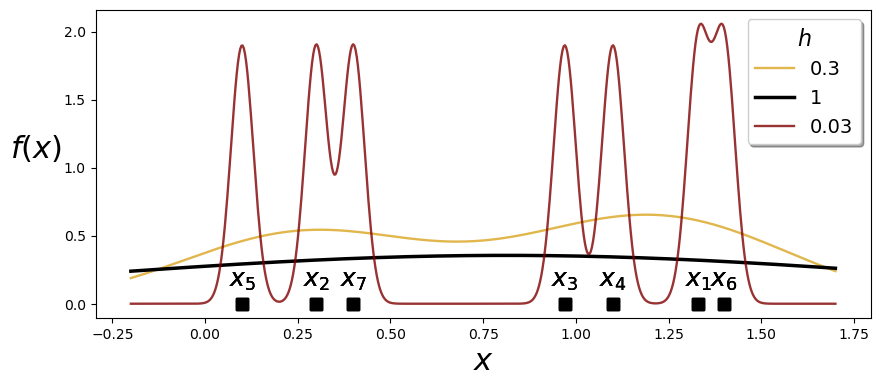

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# the Kernel function
def K(x):
    return np.exp(-x**2/2)/np.sqrt(2*np.pi)

# dummy dataset
dataset = np.array([1.33, 0.3, 0.97, 1.1, 0.1, 1.4, 0.4])

# x-value range for plotting KDEs
x_range = np.linspace(dataset.min()-0.3, dataset.max()+0.3, num=600)

# bandwith values for experimentation
H = [0.3, 1, 0.03]
n_samples = dataset.size

# line properties for different bandwith values
color_list = ['goldenrod', 'black', 'maroon']
alpha_list = [0.8, 1, 0.8]
width_list = [1.7,2.5,1.7]

plt.figure(figsize=(10,4))
# iterate over bandwith values
for h, color, alpha, width in zip(H, color_list, alpha_list, width_list):
    total_sum = 0
    # iterate over datapoints
    for i, xi in enumerate(dataset):
        total_sum += K((x_range - xi) / h)
        plt.annotate(r'$x_{}$'.format(i+1),
                     xy=[xi, 0.13],
                     horizontalalignment='center',
                     fontsize=18,
                    )
    y_range = total_sum/(h*n_samples)
    plt.plot(x_range, y_range, 
             color=color, alpha=alpha, linewidth=width, 
             label=f'{h}')

    plt.plot(dataset, np.zeros_like(dataset) , 's', 
             markersize=8, color='black')
    
plt.xlabel('$x$', fontsize=22)
plt.ylabel('$f(x)$', fontsize=22, rotation='horizontal', labelpad=20)
plt.legend(fontsize=14, shadow=True, title='$h$', title_fontsize=16)
plt.show()

<br>

<p style="text-align:center; font-weight:bold; font-size:17px;">Exotic Backtest: Dual Digital</p>

<p style="text-align:center; font-size:14px;">In this notebook, we want to price a up, up dual digital option using montecarlo and numerical integration.</p<

In [1]:
#-------
# IMPORT PUBLIC LIBRAIRIES
#-------
import numpy as np
import pandas as pd
import plotly.express as px

#-------
# IMPORT PRIVATE LIBRAIRIES
#-------
from module.pricing import dual_digital
# -----
# SET DISPLAY SETTINGS
# -----
pd.set_option('display.float_format', '{:,.4f}'.format)
pd.set_option('display.width', 100)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

In [2]:
#-------
# PRICING PARAMETER
#-------
S0_1 = 4500
S0_2 = 4500
K1 = 4500
K2 = 4500
sigma_1 = 0.2
sigma_2 = 0.2
rho = 0.5
r = 0.0
maturity = 252
d1 = 'down'
d2 = 'down'

In [3]:
bump_size = 0.0001
S1_1 = S0_1 * (1 + bump_size)
S1_2 = S0_2 * (1 + bump_size)
pv_no_bump = dual_digital(S0_1, S0_2, K1, K2, sigma_1, sigma_2, d1, d2, rho, r, maturity, periods_per_year=252)
pv_s1_bumped = dual_digital(S1_1, S0_2, K1, K2, sigma_1, sigma_2, d1, d2, rho, r, maturity, periods_per_year=252)
pv_s2_bumped = dual_digital(S0_1, S1_2, K1, K2, sigma_1, sigma_2, d1, d2, rho, r, maturity, periods_per_year=252)
delta_s1 = (pv_s1_bumped-pv_no_bump)/(bump_size*S0_1)
delta_s2 = (pv_s2_bumped-pv_no_bump)/(bump_size*S0_2)

In [4]:
# -----
# GLOBAL INPUT
# -----
file_path = 'data/'
asset_list = ['SPY', 'IWM']

# -----
# IMPORT DATA
# -----
file_path_asset1 = file_path + asset_list[0] + ".csv"
file_path_asset2 = file_path + asset_list[1] + ".csv"
close_price_asset1_pd = pd.read_csv(file_path_asset1, index_col=0, parse_dates=True)['Adj Close']
close_price_asset2_pd = pd.read_csv(file_path_asset2, index_col=0, parse_dates=True)['Adj Close']

# -----
# RESHAPE DATA
# -----
common_index = sorted(set(close_price_asset1_pd.index).intersection(close_price_asset2_pd.index))
close_price_asset1_pd = close_price_asset1_pd.loc[common_index]
close_price_asset2_pd = close_price_asset2_pd.loc[common_index]
close_price = pd.concat([close_price_asset1_pd, close_price_asset2_pd], axis=1)
close_price.columns = ['Asset1', 'Asset2']
close_price = close_price.iloc[-252:]

In [5]:
close_price.shape[0]

252

In [7]:
i = close_price.shape[0]
K1 = close_price.iloc[0]['Asset1']
K2 = close_price.iloc[0]['Asset2']
sigma_1 = 0.16
sigma_2 = 0.21
rho = 0.99
r = 0.0
d1 = 'up'
d2 = 'up'
pricing_details = dict()
for index in close_price.index:
    
    #-------
    # PRICING PARAMETER
    #-------
    S0_1 = close_price.loc[index, 'Asset1']
    S0_2 = close_price.loc[index, 'Asset2']
    maturity = i
    i = i - 1
    bump_size = 0.0001
    S1_1 = S0_1 * (1 + bump_size)
    S1_2 = S0_2 * (1 + bump_size)
    pv_no_bump = dual_digital(S0_1, S0_2, K1, K2, sigma_1, sigma_2, d1, d2, rho, r, maturity, periods_per_year=252)
    pv_s1_bumped = dual_digital(S1_1, S0_2, K1, K2, sigma_1, sigma_2, d1, d2, rho, r, maturity, periods_per_year=252)
    pv_s2_bumped = dual_digital(S0_1, S1_2, K1, K2, sigma_1, sigma_2, d1, d2, rho, r, maturity, periods_per_year=252)
    delta_s1 = (pv_s1_bumped-pv_no_bump)/(bump_size*S0_1)
    delta_s2 = (pv_s2_bumped-pv_no_bump)/(bump_size*S0_2)
    pricing_details[index] = [pv_no_bump, delta_s1, delta_s2]
    print(pricing_details[index])

[0.4196664048683078, 0.002116130878654895, 0.0064171926090842105]
[0.48372691508708965, 0.0016363698607819615, 0.006420926145550285]
[0.4741311199698579, 0.0013011602170169116, 0.007109791047862663]
[0.46147236263022445, 0.0021647442002876633, 0.005990081563716702]
[0.4065759238815041, 0.0031569606366752133, 0.004965508106351398]
[0.393120851665212, 0.003635466300024288, 0.004295522722825738]
[0.38430599313928593, 0.004424711717226065, 0.003087552630540734]
[0.37776818393504114, 0.004578877146699142, 0.0028884175966329]
[0.43047199212776344, 0.0035952776236289523, 0.004212437617767762]
[0.3809569302100708, 0.004063738881938104, 0.003800835791032042]
[0.4369150055145808, 0.003627729834895133, 0.0038526662905011082]
[0.4606044364838143, 0.003260348415335858, 0.004543213127032545]
[0.4381586557464259, 0.002613311495023518, 0.005812990084923275]
[0.41766671411107087, 0.0025374672338039157, 0.006131540048487938]
[0.45983489051974885, 0.0013316922977997497, 0.007615623277620556]
[0.469815291

/Users/kevin/anaconda3/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


[0.5292902803711035, -0.0005476941326679817, 0.012693024651373926]
[0.5448500014176516, -0.0016838813699084287, 0.011151281422438293]
[0.5566082627248057, -0.0027376230984140376, 0.01101600236400763]
[0.5486811339458931, -0.0016956564311037669, 0.011175460634937611]
[0.5118467788592153, -0.0010723624175896537, 0.01151253317930672]
[0.5013599752972403, -0.0005649393641992676, 0.011157885011902926]
[0.4770078470603065, -0.0010019968997736959, 0.01377479969828201]
[0.4874474071512045, -0.00039822640978914083, 0.01126112562909898]
[0.5178558945212536, -0.0006973019452928589, 0.011207383331397041]
[0.4957353083853472, -0.0006835341432427729, 0.010970456247511718]
[0.5041163919624784, -0.0004770052472668691, 0.010133385594217085]
[0.4921547804738278, -0.0004879541442709834, 0.0114767080539293]
[0.46350538724426876, -0.00026327445480549575, 0.011633898225258803]
[0.51041876085023, -0.0004485893068798983, 0.011197198219541986]
[0.5059023690384615, -0.0003499179163930272, 0.01121916369990734]
[

In [8]:
df = pd.DataFrame.from_dict(pricing_details, orient='index')
df.columns = ['PV', 'Asset1', 'Asset2']
#df = pd.concat([close_price, df], axis=1)

In [9]:
df.loc[:, 'OptionPnL'] = df['PV'].diff()
df.loc[:, 'DeltaPnL'] = close_price.diff().multiply(df[['Asset1', 'Asset2']].shift()).sum(axis=1)

In [10]:
test = pd.concat([df.loc[:, 'OptionPnL'].cumsum(), df.loc[:, 'DeltaPnL'].cumsum()], axis=1)

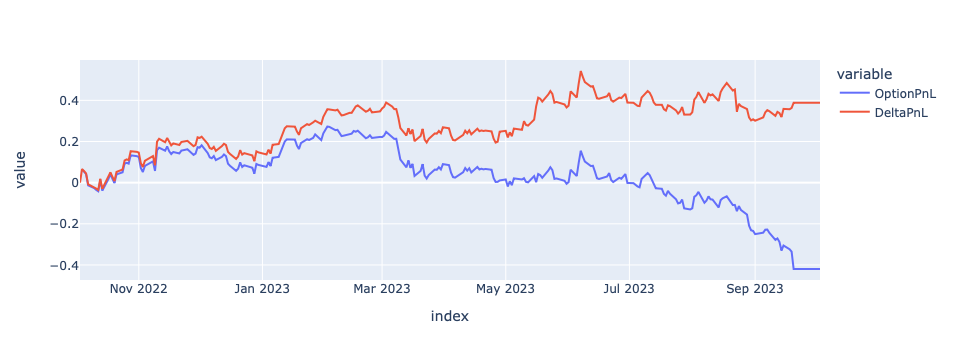

In [11]:
px.line(test)